

##  Create the best autoencoder for the three meter dataset you can (best measured by MAE, more info in file), noting that the network must have at least one layer with less than half the number of datapoints rounded down

* Reasonable hyperparameters are all that is needed, please describe the optimization process in your writeup and do not make the hyperparameter search run by default
 






In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.utils.data as data_utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# !pip install torchsummary 
from torchsummary import summary
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

torch.backends.cudnn.benchmark=True

# Loading the Training and Testing Data using Data Loader 

In [2]:
# Loading the Training and Testing Data
X = pd.read_csv('./Three Meter/data.csv')

In [3]:
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [4]:
X.shape

(139201, 33)

In [5]:
# Splitting the Data into Training and Test Data    trainImages.max(axis=0)
X_train, X_test = train_test_split(X, test_size=0.15, shuffle = True)

# batch_size
batch = 256

# Train Data Loader
train = data_utils.TensorDataset(torch.from_numpy(X_train).float(),torch.from_numpy(X_train).float())
train_loader = data_utils.DataLoader(train, batch_size=batch, shuffle=True)

# Test Data loader
test = data_utils.TensorDataset(torch.from_numpy(X_test).float(),torch.from_numpy(X_test).float())
test_loader = data_utils.DataLoader(test)



# Showing the Training Data after Normalizing

In [6]:
# Preview the training data
for batch_idx, (data,label) in enumerate(train_loader):
    print("Training Data")
    print(label.shape)

    break
    

Training Data
torch.Size([256, 33])


## Defining Convolution Neural Network

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(33, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 33),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
net = Net()
net.to(device)

Net(
  (encoder): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=33, bias=True)
    (7): Tanh()
  )
)

In [8]:
summary(net,input_size = (1,33),batch_size=batch)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [256, 1, 128]           4,352
              ReLU-2              [256, 1, 128]               0
            Linear-3               [256, 1, 64]           8,256
              ReLU-4               [256, 1, 64]               0
            Linear-5               [256, 1, 12]             780
              ReLU-6               [256, 1, 12]               0
            Linear-7                [256, 1, 3]              39
            Linear-8               [256, 1, 12]              48
              ReLU-9               [256, 1, 12]               0
           Linear-10               [256, 1, 64]             832
             ReLU-11               [256, 1, 64]               0
           Linear-12              [256, 1, 128]           8,320
             ReLU-13              [256, 1, 128]               0
           Linear-14               [256

In [9]:
params = list(net.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

# params

##  Define a Loss function and optimizer

In [10]:
import torch.optim as optim

criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

In [11]:
# output = net(data)
#         print(target.dtype,output.dtype)
# loss = criterion(output, output)
# loss.backward()
# optimizer.step()
# torch.sum(output==target)


In [12]:
data[0].shape

torch.Size([33])


## Training and Testing

In [16]:
def train(model, train_loader, optimizer, epoch,device):
    model.train()
    training_loss = 0
    lo = []
    for batch_idx, (data,target) in enumerate(train_loader):
        data,target = data.to(device), target.to(device)

        #=====Forward====
        output = model(data)
        loss = criterion(output, target)
         #=====Backward====
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #=== Loss Calculation
        lo.append(loss.item()/batch)
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/batch))
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    model.eval()
    test_loss = 0
    testlo = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #== Forward===
            output = model(data)
            test_loss = criterion(output, target)
            #=== Test loss====
            testlo.append(test_loss.item()/batch)
    val_loss.append(np.mean(testlo))
    print('\nTest set: Average loss: {:.4f}\n'.format(np.mean(testlo)))

In [17]:
device

device(type='cuda', index=0)

# Training the Model

In [18]:
epochs = 50
for epoch in range(1, epochs + 1):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 1 [0/118320 (0%)]	Loss: 0.003310
Train Epoch: 1 [2560/118320 (2%)]	Loss: 0.003252
Train Epoch: 1 [5120/118320 (4%)]	Loss: 0.003275
Train Epoch: 1 [7680/118320 (6%)]	Loss: 0.003264
Train Epoch: 1 [10240/118320 (9%)]	Loss: 0.003237
Train Epoch: 1 [12800/118320 (11%)]	Loss: 0.003290
Train Epoch: 1 [15360/118320 (13%)]	Loss: 0.003288
Train Epoch: 1 [17920/118320 (15%)]	Loss: 0.003258
Train Epoch: 1 [20480/118320 (17%)]	Loss: 0.003252
Train Epoch: 1 [23040/118320 (19%)]	Loss: 0.003256
Train Epoch: 1 [25600/118320 (22%)]	Loss: 0.003273
Train Epoch: 1 [28160/118320 (24%)]	Loss: 0.003262
Train Epoch: 1 [30720/118320 (26%)]	Loss: 0.003268
Train Epoch: 1 [33280/118320 (28%)]	Loss: 0.003273
Train Epoch: 1 [35840/118320 (30%)]	Loss: 0.003232
Train Epoch: 1 [38400/118320 (32%)]	Loss: 0.003281
Train Epoch: 1 [40960/118320 (35%)]	Loss: 0.003279
Train Epoch: 1 [43520/118320 (37%)]	Loss: 0.003295
Train Epoch: 1 [46080/118320 (39%)]	Loss: 0.003254
Train Epoch: 1 [48640/118320 (41%)]	Loss: 0

Train Epoch: 4 [53760/118320 (45%)]	Loss: 0.003296
Train Epoch: 4 [56320/118320 (48%)]	Loss: 0.003231
Train Epoch: 4 [58880/118320 (50%)]	Loss: 0.003260
Train Epoch: 4 [61440/118320 (52%)]	Loss: 0.003276
Train Epoch: 4 [64000/118320 (54%)]	Loss: 0.003276
Train Epoch: 4 [66560/118320 (56%)]	Loss: 0.003260
Train Epoch: 4 [69120/118320 (58%)]	Loss: 0.003294
Train Epoch: 4 [71680/118320 (60%)]	Loss: 0.003258
Train Epoch: 4 [74240/118320 (63%)]	Loss: 0.003290
Train Epoch: 4 [76800/118320 (65%)]	Loss: 0.003272
Train Epoch: 4 [79360/118320 (67%)]	Loss: 0.003245
Train Epoch: 4 [81920/118320 (69%)]	Loss: 0.003245
Train Epoch: 4 [84480/118320 (71%)]	Loss: 0.003252
Train Epoch: 4 [87040/118320 (73%)]	Loss: 0.003249
Train Epoch: 4 [89600/118320 (76%)]	Loss: 0.003253
Train Epoch: 4 [92160/118320 (78%)]	Loss: 0.003235
Train Epoch: 4 [94720/118320 (80%)]	Loss: 0.003296
Train Epoch: 4 [97280/118320 (82%)]	Loss: 0.003249
Train Epoch: 4 [99840/118320 (84%)]	Loss: 0.003318
Train Epoch: 4 [102400/118320 (

Train Epoch: 7 [104960/118320 (89%)]	Loss: 0.003288
Train Epoch: 7 [107520/118320 (91%)]	Loss: 0.003270
Train Epoch: 7 [110080/118320 (93%)]	Loss: 0.003274
Train Epoch: 7 [112640/118320 (95%)]	Loss: 0.003262
Train Epoch: 7 [115200/118320 (97%)]	Loss: 0.003269
Train Epoch: 7 [117760/118320 (99%)]	Loss: 0.003265

Test set: Average loss: 0.0033

Train Epoch: 8 [0/118320 (0%)]	Loss: 0.003264
Train Epoch: 8 [2560/118320 (2%)]	Loss: 0.003245
Train Epoch: 8 [5120/118320 (4%)]	Loss: 0.003249
Train Epoch: 8 [7680/118320 (6%)]	Loss: 0.003238
Train Epoch: 8 [10240/118320 (9%)]	Loss: 0.003287
Train Epoch: 8 [12800/118320 (11%)]	Loss: 0.003256
Train Epoch: 8 [15360/118320 (13%)]	Loss: 0.003255
Train Epoch: 8 [17920/118320 (15%)]	Loss: 0.003259
Train Epoch: 8 [20480/118320 (17%)]	Loss: 0.003272
Train Epoch: 8 [23040/118320 (19%)]	Loss: 0.003268
Train Epoch: 8 [25600/118320 (22%)]	Loss: 0.003270
Train Epoch: 8 [28160/118320 (24%)]	Loss: 0.003281
Train Epoch: 8 [30720/118320 (26%)]	Loss: 0.003271
Trai

Train Epoch: 11 [35840/118320 (30%)]	Loss: 0.003283
Train Epoch: 11 [38400/118320 (32%)]	Loss: 0.003267
Train Epoch: 11 [40960/118320 (35%)]	Loss: 0.003295
Train Epoch: 11 [43520/118320 (37%)]	Loss: 0.003254
Train Epoch: 11 [46080/118320 (39%)]	Loss: 0.003287
Train Epoch: 11 [48640/118320 (41%)]	Loss: 0.003270
Train Epoch: 11 [51200/118320 (43%)]	Loss: 0.003271
Train Epoch: 11 [53760/118320 (45%)]	Loss: 0.003245
Train Epoch: 11 [56320/118320 (48%)]	Loss: 0.003252
Train Epoch: 11 [58880/118320 (50%)]	Loss: 0.003276
Train Epoch: 11 [61440/118320 (52%)]	Loss: 0.003268
Train Epoch: 11 [64000/118320 (54%)]	Loss: 0.003280
Train Epoch: 11 [66560/118320 (56%)]	Loss: 0.003258
Train Epoch: 11 [69120/118320 (58%)]	Loss: 0.003267
Train Epoch: 11 [71680/118320 (60%)]	Loss: 0.003228
Train Epoch: 11 [74240/118320 (63%)]	Loss: 0.003231
Train Epoch: 11 [76800/118320 (65%)]	Loss: 0.003293
Train Epoch: 11 [79360/118320 (67%)]	Loss: 0.003278
Train Epoch: 11 [81920/118320 (69%)]	Loss: 0.003233
Train Epoch:

Train Epoch: 14 [87040/118320 (73%)]	Loss: 0.003287
Train Epoch: 14 [89600/118320 (76%)]	Loss: 0.003275
Train Epoch: 14 [92160/118320 (78%)]	Loss: 0.003262
Train Epoch: 14 [94720/118320 (80%)]	Loss: 0.003205
Train Epoch: 14 [97280/118320 (82%)]	Loss: 0.003265
Train Epoch: 14 [99840/118320 (84%)]	Loss: 0.003221
Train Epoch: 14 [102400/118320 (86%)]	Loss: 0.003281
Train Epoch: 14 [104960/118320 (89%)]	Loss: 0.003272
Train Epoch: 14 [107520/118320 (91%)]	Loss: 0.003238
Train Epoch: 14 [110080/118320 (93%)]	Loss: 0.003274
Train Epoch: 14 [112640/118320 (95%)]	Loss: 0.003244
Train Epoch: 14 [115200/118320 (97%)]	Loss: 0.003257
Train Epoch: 14 [117760/118320 (99%)]	Loss: 0.003271

Test set: Average loss: 0.0033

Train Epoch: 15 [0/118320 (0%)]	Loss: 0.003296
Train Epoch: 15 [2560/118320 (2%)]	Loss: 0.003258
Train Epoch: 15 [5120/118320 (4%)]	Loss: 0.003203
Train Epoch: 15 [7680/118320 (6%)]	Loss: 0.003226
Train Epoch: 15 [10240/118320 (9%)]	Loss: 0.003238
Train Epoch: 15 [12800/118320 (11%)]

Train Epoch: 18 [17920/118320 (15%)]	Loss: 0.003221
Train Epoch: 18 [20480/118320 (17%)]	Loss: 0.003213
Train Epoch: 18 [23040/118320 (19%)]	Loss: 0.003235
Train Epoch: 18 [25600/118320 (22%)]	Loss: 0.003208
Train Epoch: 18 [28160/118320 (24%)]	Loss: 0.003238
Train Epoch: 18 [30720/118320 (26%)]	Loss: 0.003221
Train Epoch: 18 [33280/118320 (28%)]	Loss: 0.003224
Train Epoch: 18 [35840/118320 (30%)]	Loss: 0.003217
Train Epoch: 18 [38400/118320 (32%)]	Loss: 0.003241
Train Epoch: 18 [40960/118320 (35%)]	Loss: 0.003195
Train Epoch: 18 [43520/118320 (37%)]	Loss: 0.003225
Train Epoch: 18 [46080/118320 (39%)]	Loss: 0.003220
Train Epoch: 18 [48640/118320 (41%)]	Loss: 0.003217
Train Epoch: 18 [51200/118320 (43%)]	Loss: 0.003180
Train Epoch: 18 [53760/118320 (45%)]	Loss: 0.003220
Train Epoch: 18 [56320/118320 (48%)]	Loss: 0.003214
Train Epoch: 18 [58880/118320 (50%)]	Loss: 0.003240
Train Epoch: 18 [61440/118320 (52%)]	Loss: 0.003186
Train Epoch: 18 [64000/118320 (54%)]	Loss: 0.003236
Train Epoch:

Train Epoch: 21 [69120/118320 (58%)]	Loss: 0.002903
Train Epoch: 21 [71680/118320 (60%)]	Loss: 0.002849
Train Epoch: 21 [74240/118320 (63%)]	Loss: 0.002912
Train Epoch: 21 [76800/118320 (65%)]	Loss: 0.002851
Train Epoch: 21 [79360/118320 (67%)]	Loss: 0.002863
Train Epoch: 21 [81920/118320 (69%)]	Loss: 0.002862
Train Epoch: 21 [84480/118320 (71%)]	Loss: 0.002853
Train Epoch: 21 [87040/118320 (73%)]	Loss: 0.002889
Train Epoch: 21 [89600/118320 (76%)]	Loss: 0.002925
Train Epoch: 21 [92160/118320 (78%)]	Loss: 0.002872
Train Epoch: 21 [94720/118320 (80%)]	Loss: 0.002847
Train Epoch: 21 [97280/118320 (82%)]	Loss: 0.002874
Train Epoch: 21 [99840/118320 (84%)]	Loss: 0.002873
Train Epoch: 21 [102400/118320 (86%)]	Loss: 0.002800
Train Epoch: 21 [104960/118320 (89%)]	Loss: 0.002881
Train Epoch: 21 [107520/118320 (91%)]	Loss: 0.002866
Train Epoch: 21 [110080/118320 (93%)]	Loss: 0.002824
Train Epoch: 21 [112640/118320 (95%)]	Loss: 0.002854
Train Epoch: 21 [115200/118320 (97%)]	Loss: 0.002876
Train 


Test set: Average loss: 0.0027

Train Epoch: 25 [0/118320 (0%)]	Loss: 0.002595
Train Epoch: 25 [2560/118320 (2%)]	Loss: 0.002644
Train Epoch: 25 [5120/118320 (4%)]	Loss: 0.002683
Train Epoch: 25 [7680/118320 (6%)]	Loss: 0.002672
Train Epoch: 25 [10240/118320 (9%)]	Loss: 0.002670
Train Epoch: 25 [12800/118320 (11%)]	Loss: 0.002711
Train Epoch: 25 [15360/118320 (13%)]	Loss: 0.002705
Train Epoch: 25 [17920/118320 (15%)]	Loss: 0.002677
Train Epoch: 25 [20480/118320 (17%)]	Loss: 0.002690
Train Epoch: 25 [23040/118320 (19%)]	Loss: 0.002619
Train Epoch: 25 [25600/118320 (22%)]	Loss: 0.002661
Train Epoch: 25 [28160/118320 (24%)]	Loss: 0.002691
Train Epoch: 25 [30720/118320 (26%)]	Loss: 0.002674
Train Epoch: 25 [33280/118320 (28%)]	Loss: 0.002693
Train Epoch: 25 [35840/118320 (30%)]	Loss: 0.002681
Train Epoch: 25 [38400/118320 (32%)]	Loss: 0.002748
Train Epoch: 25 [40960/118320 (35%)]	Loss: 0.002682
Train Epoch: 25 [43520/118320 (37%)]	Loss: 0.002623
Train Epoch: 25 [46080/118320 (39%)]	Loss: 

Train Epoch: 28 [53760/118320 (45%)]	Loss: 0.002672
Train Epoch: 28 [56320/118320 (48%)]	Loss: 0.002667
Train Epoch: 28 [58880/118320 (50%)]	Loss: 0.002677
Train Epoch: 28 [61440/118320 (52%)]	Loss: 0.002616
Train Epoch: 28 [64000/118320 (54%)]	Loss: 0.002602
Train Epoch: 28 [66560/118320 (56%)]	Loss: 0.002696
Train Epoch: 28 [69120/118320 (58%)]	Loss: 0.002628
Train Epoch: 28 [71680/118320 (60%)]	Loss: 0.002691
Train Epoch: 28 [74240/118320 (63%)]	Loss: 0.002610
Train Epoch: 28 [76800/118320 (65%)]	Loss: 0.002681
Train Epoch: 28 [79360/118320 (67%)]	Loss: 0.002663
Train Epoch: 28 [81920/118320 (69%)]	Loss: 0.002681
Train Epoch: 28 [84480/118320 (71%)]	Loss: 0.002669
Train Epoch: 28 [87040/118320 (73%)]	Loss: 0.002654
Train Epoch: 28 [89600/118320 (76%)]	Loss: 0.002687
Train Epoch: 28 [92160/118320 (78%)]	Loss: 0.002650
Train Epoch: 28 [94720/118320 (80%)]	Loss: 0.002657
Train Epoch: 28 [97280/118320 (82%)]	Loss: 0.002663
Train Epoch: 28 [99840/118320 (84%)]	Loss: 0.002655
Train Epoch:

Train Epoch: 31 [107520/118320 (91%)]	Loss: 0.002619
Train Epoch: 31 [110080/118320 (93%)]	Loss: 0.002651
Train Epoch: 31 [112640/118320 (95%)]	Loss: 0.002616
Train Epoch: 31 [115200/118320 (97%)]	Loss: 0.002700
Train Epoch: 31 [117760/118320 (99%)]	Loss: 0.002684

Test set: Average loss: 0.0026

Train Epoch: 32 [0/118320 (0%)]	Loss: 0.002623
Train Epoch: 32 [2560/118320 (2%)]	Loss: 0.002633
Train Epoch: 32 [5120/118320 (4%)]	Loss: 0.002648
Train Epoch: 32 [7680/118320 (6%)]	Loss: 0.002607
Train Epoch: 32 [10240/118320 (9%)]	Loss: 0.002667
Train Epoch: 32 [12800/118320 (11%)]	Loss: 0.002583
Train Epoch: 32 [15360/118320 (13%)]	Loss: 0.002644
Train Epoch: 32 [17920/118320 (15%)]	Loss: 0.002658
Train Epoch: 32 [20480/118320 (17%)]	Loss: 0.002640
Train Epoch: 32 [23040/118320 (19%)]	Loss: 0.002664
Train Epoch: 32 [25600/118320 (22%)]	Loss: 0.002660
Train Epoch: 32 [28160/118320 (24%)]	Loss: 0.002611
Train Epoch: 32 [30720/118320 (26%)]	Loss: 0.002633
Train Epoch: 32 [33280/118320 (28%)]	L

Train Epoch: 35 [38400/118320 (32%)]	Loss: 0.002602
Train Epoch: 35 [40960/118320 (35%)]	Loss: 0.002625
Train Epoch: 35 [43520/118320 (37%)]	Loss: 0.002630
Train Epoch: 35 [46080/118320 (39%)]	Loss: 0.002600
Train Epoch: 35 [48640/118320 (41%)]	Loss: 0.002622
Train Epoch: 35 [51200/118320 (43%)]	Loss: 0.002617
Train Epoch: 35 [53760/118320 (45%)]	Loss: 0.002654
Train Epoch: 35 [56320/118320 (48%)]	Loss: 0.002671
Train Epoch: 35 [58880/118320 (50%)]	Loss: 0.002639
Train Epoch: 35 [61440/118320 (52%)]	Loss: 0.002571
Train Epoch: 35 [64000/118320 (54%)]	Loss: 0.002607
Train Epoch: 35 [66560/118320 (56%)]	Loss: 0.002586
Train Epoch: 35 [69120/118320 (58%)]	Loss: 0.002653
Train Epoch: 35 [71680/118320 (60%)]	Loss: 0.002614
Train Epoch: 35 [74240/118320 (63%)]	Loss: 0.002624
Train Epoch: 35 [76800/118320 (65%)]	Loss: 0.002581
Train Epoch: 35 [79360/118320 (67%)]	Loss: 0.002640
Train Epoch: 35 [81920/118320 (69%)]	Loss: 0.002588
Train Epoch: 35 [84480/118320 (71%)]	Loss: 0.002667
Train Epoch:

Train Epoch: 38 [87040/118320 (73%)]	Loss: 0.002632
Train Epoch: 38 [89600/118320 (76%)]	Loss: 0.002563
Train Epoch: 38 [92160/118320 (78%)]	Loss: 0.002566
Train Epoch: 38 [94720/118320 (80%)]	Loss: 0.002576
Train Epoch: 38 [97280/118320 (82%)]	Loss: 0.002641
Train Epoch: 38 [99840/118320 (84%)]	Loss: 0.002613
Train Epoch: 38 [102400/118320 (86%)]	Loss: 0.002572
Train Epoch: 38 [104960/118320 (89%)]	Loss: 0.002588
Train Epoch: 38 [107520/118320 (91%)]	Loss: 0.002611
Train Epoch: 38 [110080/118320 (93%)]	Loss: 0.002555
Train Epoch: 38 [112640/118320 (95%)]	Loss: 0.002599
Train Epoch: 38 [115200/118320 (97%)]	Loss: 0.002593
Train Epoch: 38 [117760/118320 (99%)]	Loss: 0.002599

Test set: Average loss: 0.0026

Train Epoch: 39 [0/118320 (0%)]	Loss: 0.002541
Train Epoch: 39 [2560/118320 (2%)]	Loss: 0.002575
Train Epoch: 39 [5120/118320 (4%)]	Loss: 0.002580
Train Epoch: 39 [7680/118320 (6%)]	Loss: 0.002567
Train Epoch: 39 [10240/118320 (9%)]	Loss: 0.002534
Train Epoch: 39 [12800/118320 (11%)]

Train Epoch: 42 [17920/118320 (15%)]	Loss: 0.002140
Train Epoch: 42 [20480/118320 (17%)]	Loss: 0.002106
Train Epoch: 42 [23040/118320 (19%)]	Loss: 0.002074
Train Epoch: 42 [25600/118320 (22%)]	Loss: 0.002098
Train Epoch: 42 [28160/118320 (24%)]	Loss: 0.002057
Train Epoch: 42 [30720/118320 (26%)]	Loss: 0.002095
Train Epoch: 42 [33280/118320 (28%)]	Loss: 0.002096
Train Epoch: 42 [35840/118320 (30%)]	Loss: 0.002120
Train Epoch: 42 [38400/118320 (32%)]	Loss: 0.002098
Train Epoch: 42 [40960/118320 (35%)]	Loss: 0.002113
Train Epoch: 42 [43520/118320 (37%)]	Loss: 0.002071
Train Epoch: 42 [46080/118320 (39%)]	Loss: 0.002076
Train Epoch: 42 [48640/118320 (41%)]	Loss: 0.002072
Train Epoch: 42 [51200/118320 (43%)]	Loss: 0.002079
Train Epoch: 42 [53760/118320 (45%)]	Loss: 0.002114
Train Epoch: 42 [56320/118320 (48%)]	Loss: 0.002054
Train Epoch: 42 [58880/118320 (50%)]	Loss: 0.002085
Train Epoch: 42 [61440/118320 (52%)]	Loss: 0.002076
Train Epoch: 42 [64000/118320 (54%)]	Loss: 0.002113
Train Epoch:

Train Epoch: 45 [71680/118320 (60%)]	Loss: 0.002028
Train Epoch: 45 [74240/118320 (63%)]	Loss: 0.002076
Train Epoch: 45 [76800/118320 (65%)]	Loss: 0.002093
Train Epoch: 45 [79360/118320 (67%)]	Loss: 0.002077
Train Epoch: 45 [81920/118320 (69%)]	Loss: 0.002090
Train Epoch: 45 [84480/118320 (71%)]	Loss: 0.002024
Train Epoch: 45 [87040/118320 (73%)]	Loss: 0.002029
Train Epoch: 45 [89600/118320 (76%)]	Loss: 0.002054
Train Epoch: 45 [92160/118320 (78%)]	Loss: 0.002046
Train Epoch: 45 [94720/118320 (80%)]	Loss: 0.002050
Train Epoch: 45 [97280/118320 (82%)]	Loss: 0.002096
Train Epoch: 45 [99840/118320 (84%)]	Loss: 0.002081
Train Epoch: 45 [102400/118320 (86%)]	Loss: 0.002074
Train Epoch: 45 [104960/118320 (89%)]	Loss: 0.002043
Train Epoch: 45 [107520/118320 (91%)]	Loss: 0.002049
Train Epoch: 45 [110080/118320 (93%)]	Loss: 0.002066
Train Epoch: 45 [112640/118320 (95%)]	Loss: 0.002066
Train Epoch: 45 [115200/118320 (97%)]	Loss: 0.002038
Train Epoch: 45 [117760/118320 (99%)]	Loss: 0.002045

Test


Test set: Average loss: 0.0020

Train Epoch: 49 [0/118320 (0%)]	Loss: 0.002014
Train Epoch: 49 [2560/118320 (2%)]	Loss: 0.002045
Train Epoch: 49 [5120/118320 (4%)]	Loss: 0.002023
Train Epoch: 49 [7680/118320 (6%)]	Loss: 0.002071
Train Epoch: 49 [10240/118320 (9%)]	Loss: 0.002050
Train Epoch: 49 [12800/118320 (11%)]	Loss: 0.002032
Train Epoch: 49 [15360/118320 (13%)]	Loss: 0.002044
Train Epoch: 49 [17920/118320 (15%)]	Loss: 0.002013
Train Epoch: 49 [20480/118320 (17%)]	Loss: 0.002049
Train Epoch: 49 [23040/118320 (19%)]	Loss: 0.002045
Train Epoch: 49 [25600/118320 (22%)]	Loss: 0.002056
Train Epoch: 49 [28160/118320 (24%)]	Loss: 0.002045
Train Epoch: 49 [30720/118320 (26%)]	Loss: 0.002045
Train Epoch: 49 [33280/118320 (28%)]	Loss: 0.002043
Train Epoch: 49 [35840/118320 (30%)]	Loss: 0.002029
Train Epoch: 49 [38400/118320 (32%)]	Loss: 0.001998
Train Epoch: 49 [40960/118320 (35%)]	Loss: 0.002048
Train Epoch: 49 [43520/118320 (37%)]	Loss: 0.002045
Train Epoch: 49 [46080/118320 (39%)]	Loss: 

Training Loss: 0.0020360895261554686

Test Loss: 0.002033973118952146



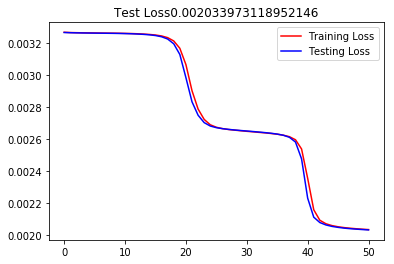

In [20]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
# print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', val_loss[-1])
# print('Testing Accuracy:', test_accu[-1])
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss' + str(val_loss[-1]))
plt.legend()
plt.show()
# plt.plot(train_accu,'r', label='Training accuracy')
# plt.plot(test_accu,'b', label='Testing accuracy')
# plt.title('Test Accuracy : '+ str(test_accu[-1]))
# plt.legend()
# plt.show()

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft

In [ ]:
summary(model_ft,(3,32,32))